# 预读取

In [1]:
import h5py
import cv2
import warp_norm
import matplotlib
# import sys
# sys.path.append("./FaceAlignment")
# import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import pickle
import pandas as pd
import copy
import os
from pt_module import StNet,StRefine
from ipdb import set_trace as st
import gaze_normalize

cam_chen = '/home/hgh/hghData/Datasets/camChen.xml'  # this is camera calibration information file obtained with OpenCV
fs_chen = cv2.FileStorage(cam_chen, cv2.FILE_STORAGE_READ)
camera_matrix_chen = fs_chen.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
camera_distortion_chen = fs_chen.getNode('Distortion_Coefficients').mat()

cam_tan = '/home/hgh/hghData/Datasets/camTan.xml'  # this is camera calibration information file obtained with OpenCV
fs_tan = cv2.FileStorage(cam_tan, cv2.FILE_STORAGE_READ)
camera_matrix_tan = fs_tan.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
camera_distortion_tan = fs_tan.getNode('Distortion_Coefficients').mat()

pixel_scale_tan = np.array([0.202, 0.224])
pixel_scale_chen = np.array([0.22, 0.235])

In [2]:
condition_label=['glass && upright tan','glass && upright chen',
                 'no glass && upright tan','no glass && upright chen',
                 'glass && not upright tan','glass && not upright chen',
                 'no glass && not upright tan','no glass && not upright chen',
                 'glass && indoor daylight tan', 'glass && indoor daylight chen',
                 'no glass && indoor daylight tan','no glass && indoor daylight chen',
                 'glass && only lamp tan','glass && only lamp chen',
                 'no glass && only lamp tan','no glass && only lamp chen',
                 'glass && only external lighting tan','glass && only external lighting chen',
                 'no glass && only external lighting tan','no glass && only external lighting chen',
                 'mask tan','mask chen',
                 'Normal indoor lighting at night && glass && no mask tan', 'Normal indoor lighting at night && glass && no mask chen',
                 'Normal indoor lighting at night && glass && large camera distance(70cm+) tan','Normal indoor lighting at night && glass && large camera distance(70cm+) chen',
                 'Normal indoor lighting at night && glass && middle camera distance(45-48cm) tan','Normal indoor lighting at night && glass && middle camera distance(45-48cm) chen',
                 'Normal indoor lighting at night && glass && small camera distance(32-35cm) tan','Normal indoor lighting at night && glass && small camera distance(32-35cm) chen',
                 'Normal indoor lighting at night && glass && large inclination angle(45°) tan','Normal indoor lighting at night && glass && large inclination angle(45°) chen',
                 'Normal indoor lighting at night && glass && middle inclination angle(30°) tan','Normal indoor lighting at night && glass && middle inclination angle(30°) chen',
                 'Normal indoor lighting at night && glass && small inclination angle(15°) tan','Normal indoor lighting at night && glass && small inclination angle(15°) chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone chen']
print(len(condition_label))

48


In [3]:
def get_condition_number(file_dict):
    if (1 <= file_dict <= 100):
        return 0
    if (101 <= file_dict <= 200):
        return 1
    if (201 <= file_dict <= 300):
        return 2
    if (301 <= file_dict <= 400):
        return 3
    if (401 <= file_dict <= 500):
        return 4
    if (501 <= file_dict <= 600):
        return 5
    if (601 <= file_dict <= 700):
        return 6
    if (701 <= file_dict <= 800):
        return 7
    if (801 <= file_dict <= 850):
        return 8
    if (851 <= file_dict <= 900):
        return 9
    if (901 <= file_dict <= 950):
        return 10
    if (951 <= file_dict <= 1000):
        return 11
    if (1001 <= file_dict <= 1050):
        return 12
    if (1051 <= file_dict <= 1100):
        return 13
    if (1101 <= file_dict <= 1150):
        return 14
    if (1151 <= file_dict <= 1200):
        return 15
    if (1201 <= file_dict <= 1250):
        return 16
    if (1251 <= file_dict <= 1300):
        return 17
    if (1301 <= file_dict <= 1350):
        return 18
    if (1351 <= file_dict <= 1400):
        return 19
    if (1401 <= file_dict <= 1420):
        return 20
    if (1421 <= file_dict <= 1440):
        return 21
    if (1441 <= file_dict <= 1520):
        return 22
    if (1521 <= file_dict <= 1600):
        return 23
    if (1601 <= file_dict <= 1620):
        return 24
    if (1621 <= file_dict <= 1640):
        return 25
    if (1641 <= file_dict <= 1700):
        return 26
    if (1701 <= file_dict <= 1760):
        return 27
    if (1761 <= file_dict <= 1780):
        return 28
    if (1781 <= file_dict <= 1800):
        return 29
    if (1801 <= file_dict <= 1820):
        return 30
    if (1821 <= file_dict <= 1840):
        return 31
    if (1841 <= file_dict <= 1900):
        return 32
    if (1901 <= file_dict <= 1960):
        return 33
    if (1961 <= file_dict <= 1980):
        return 34
    if (1981 <= file_dict <= 2000):
        return 35
    if (2001 <= file_dict <= 2050):
        return 36
    if (2051 <= file_dict <= 2100):
        return 37
    if (2101 <= file_dict <= 2150):
        return 38
    if (2151 <= file_dict <= 2200):
        return 39
    if (2201 <= file_dict <= 2250):
        return 40
    if (2251 <= file_dict <= 2300):
        return 41
    if (2301 <= file_dict <= 2350):
        return 42
    if (2351 <= file_dict <= 2400):
        return 43
    if (2401 <= file_dict <= 2450):
        return 44
    if (2451 <= file_dict <= 2500):
        return 45
    if (2501 <= file_dict <= 2550):
        return 46
    if (2551 <= file_dict <= 2600):
        return 47

In [4]:
# 读取数据
with open('/home/hgh/hghData/all_3_25.pkl', 'rb') as fo:
    datalist = pickle.load(fo, encoding='bytes')
    
# 分隔不同组
datalist_group = {}
for data in datalist:
    condition = get_condition_number(int(os.path.splitext(data.image_name)[0]))
    if condition not in datalist_group:
        datalist_group[condition] = []
    datalist_group[condition].append(data)

# 可视化参数

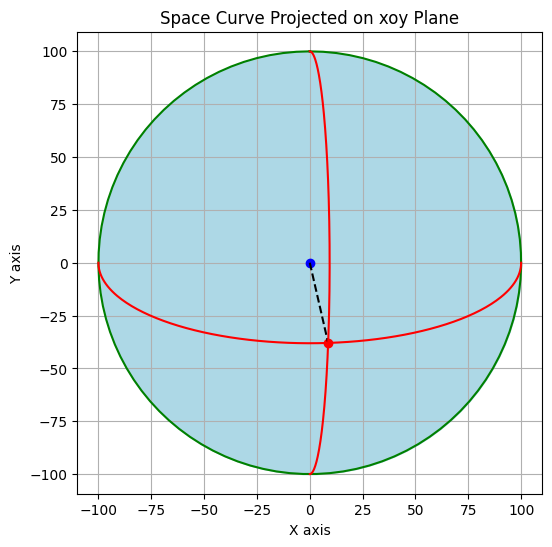

In [93]:
import numpy as np
import matplotlib.pyplot as plt


r = 100
theta_circle = np.linspace(0, 2 * np.pi, 100)
x_circle = r * np.sin(theta_circle)
y_circle = r * np.cos(theta_circle)

# 使用这个新的theta值，我们可以绕着球的一个经线绘制从北极到南极的曲线
theta_new = np.random.uniform(0, 2 * np.pi)
phi_new = np.random.uniform(0, 2 * np.pi)

# 根据phi值计算y和z坐标
x = r * np.cos(phi_new) * np.sin(theta_new)
y = r * np.sin(phi_new)
z = r * np.cos(phi_new) * np.cos(theta_new)


# 根据真实坐标还原角度并投影
# 绘制竖圆
phi_1 = np.linspace(0, np.pi, 200)
proj_v = np.array([x,z])
x_axis = np.array([1, 0])
cos_theta_1 = np.dot(proj_v,x_axis) /(np.linalg.norm(proj_v) * np.linalg.norm(x_axis))
theta_1 = np.arccos(cos_theta_1)
x_1 = r * np.sin(phi_1) * np.cos(theta_1)
y_1 = r * np.cos(phi_1)

# 绘制横圆
phi_2 = np.linspace(0, np.pi, 200)
proj_y = np.array([y,z])
y_axis = np.array([1, 0])
cos_theta_2 = np.dot(proj_y,y_axis) /(np.linalg.norm(proj_y) * np.linalg.norm(y_axis))
theta_2 = np.arccos(cos_theta_2)
x_2 = r * np.cos(phi_2)
y_2 = r * np.sin(phi_2) * np.cos(theta_2)



# 绘制曲线在xoy平面的投影
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y,'ro')
ax.plot(0,0,'bo')
ax.plot([0, x], [0, y], 'k--')
ax.plot(x_circle, y_circle, 'g-')  # 绘制圆形投影
ax.fill_between(x_circle, y_circle, color='lightblue')
ax.plot(x_1, y_1, 'r-')  # 曲线路径
ax.plot(x_2, y_2, 'r-')  # 曲线路径
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Space Curve Projected on xoy Plane')
ax.axis('equal')
ax.grid(True)

plt.show()


In [5]:
pred_errors=[]
pred_xerrors=[]
pred_yerrors=[]
for i in range(46):
    total_errors=0
    total_xerrors = 0
    total_yerrors = 0
    for j in range(len(datalist_group[i])):
        total_errors=total_errors+((datalist_group[i][j].gaze_point[0]-datalist_group[i][j].label[0])**2+(datalist_group[i][j].gaze_point[1]-datalist_group[i][j].label[1])**2)**0.5
        total_xerrors=total_xerrors+abs(datalist_group[i][j].gaze_point[0]-datalist_group[i][j].label[0])
        total_yerrors = total_yerrors + abs(datalist_group[i][j].gaze_point[1]-datalist_group[i][j].label[1])
    pred_errors.append(total_errors/(len(datalist_group[i])))
    pred_xerrors.append(total_xerrors / (len(datalist_group[i])))
    pred_yerrors.append(total_yerrors / (len(datalist_group[i])))
pred_xerrors_cm=[]
pred_yerrors_cm=[]
for i in range(46):
    if i % 2 == 0:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_tan[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_tan[1])
    else:
        pred_xerrors_cm.append(pred_xerrors[i] * 0.1 * pixel_scale_chen[0])
        pred_yerrors_cm.append(pred_yerrors[i] * 0.1 * pixel_scale_chen[1])
# print(pred_errors)
print('pred errors:')
print(pred_xerrors_cm)
print(pred_yerrors_cm)
print(pred_errors)


pred errors:
[2.3804920991146683, 4.034569169499321, 1.046865645198983, 1.894983144700813, 6.5917595764366315, 3.8946168512781036, 3.2822248044323556, 2.2906071893286684, 4.682578862928366, 9.014221228224281, 2.4616751505676824, 4.203406368220764, 12.848627707527063, 7.762271250931396, 1.3032460069510354, 4.41697353858484, 9.334313817458842, 2.284191531563183, 3.0586749127311568, 2.1431178737662604, 10.769318136531213, 5.735649065648992, 5.4539636819731285, 3.7598783916083054, 7.393825622453629, 5.034210821083007, 7.12145435716633, 3.15579258056306, 2.5283085497407467, 1.4817544073767308, 4.485307767085587, 6.35204501323141, 9.151941806790424, 2.8056688110862287, 8.61997728985458, 2.9408603355548033, 5.818352821991485, 2.885110624451074, 31.76975399867064, 17.93935061233498, 4.337918477347052, 2.7810770882763687, 27.669084713053984, 17.755430696641714, 3.2937539763643113, 2.8993833514136744]
[2.8532242424082246, 3.9745667311158104, 8.056328684985816, 4.853997907513992, 6.46964306706370

In [6]:
# condition = 2
# save_path = '/home/hgh/hghData/landmarks'
# for data in datalist_group[condition]:
#     data.image = cv2.imread(data.image_path)
#     image_out = data.draw_gaze()
#     cv2.imwrite(os.path.join(save_path, data.image_name),image_out)

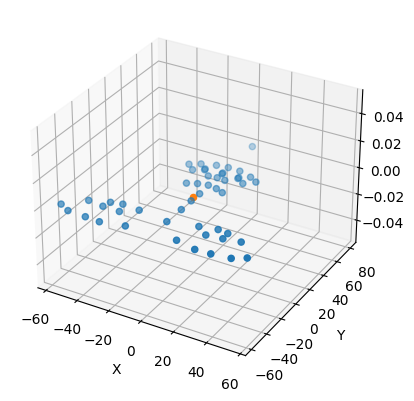

In [7]:
# 绘制参考人脸模型

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

face_model_load = np.loadtxt('./modules/face_model.txt')
# 生成一些三维数据
x = face_model_load[:,0]
y = face_model_load[:,1]
z = face_model_load[:,2]

# 绘制三维散点图
ax.scatter(x, y)
ax.scatter(0,0)

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')


# 显示图形
plt.show()


In [8]:
# # 表示每个数据
# for condition, list in datalist_group.items():
#     if condition == 19*2:
#         eulars = []
#         hts = []
#         face_distance = []
#         diff = []
#         for data in list:
#             diff.append(np.linalg.norm(data.label - data.gaze_point))
#             eulars.append(np.ravel(warp_norm.hr_to_pitchyaw(data.hr)))
#             hts.append(np.ravel(data.ht))

#         x = range(len(list))
#         # 绘制图像
#         fig, axes = plt.subplots(2, 3, constrained_layout=True)
#         # pitch 
#         axes[0,0].scatter(x,[eular[0] for eular in eulars],alpha=0.5)
#         axes[0,0].set_ylabel('Pitch [deg]')
#         axes[0,0].set_ylim(-50, 50)
#         # axes[0,0].set_ylabel('Gaze Error [pixel]')

#         # yaw 
#         axes[0,1].scatter(x,[eular[1] for eular in eulars],alpha=0.5)
#         axes[0,1].set_ylabel('Yaw [deg]')
#         axes[0,1].set_ylim(-50, 50)
#         # axes[0,1].set_ylabel('Gaze Error [pixel]')

#         # roll
#         axes[0,2].scatter(x,[eular[2] for eular in eulars],alpha=0.5)
#         axes[0,2].set_ylabel('Roll [deg]')
#         axes[0,2].set_ylim(-50, 50)
#         # axes[0,2].set_ylabel('Gaze Error [pixel]')


#         # ht x
#         axes[1,0].scatter(x,[ht[0] for ht in hts],alpha=0.5)
#         axes[1,0].set_ylabel('ht x [mm]')
#         axes[1,0].set_ylim(-100, 0)
#         # axes[1,0].set_ylabel('Gaze Error [pixel]')

#         # ht y
#         axes[1,1].scatter(x,[ht[1] for ht in hts],alpha=0.5)
#         axes[1,1].set_ylabel('ht y [mm]')
#         axes[1,1].set_ylim(-50, 50)
#         # axes[1,1].set_ylabel('Gaze Error [pixel]')

#         # ht z
#         axes[1,2].scatter(x,[ht[2] for ht in hts],alpha=0.5)
#         axes[1,2].set_ylabel('ht z [mm]')
#         axes[1,2].set_ylim(350, 500)
#         # axes[1,2].set_ylabel('Gaze Error [pixel]')

#         plt.suptitle(f'{condition_label[condition]}')   

#         plt.savefig('/home/hgh/hghData/Datasets2/result/{}.png'.format(condition_label[condition]))
#         plt.close()

In [9]:
# # xgaze method
# import matplotlib.colors as mcolors
# # 表示每个数据
# for condition, list in datalist_group.items():
#     angles = []
#     hts = []
#     face_distance = []
#     diff = []
#     for data in list:
#         diff.append(np.linalg.norm(data.label - data.gaze_point))
#         head_vector = np.dot(cv2.Rodrigues(data.hr)[0], np.array([0,0,-1]).T)
#         angles.append(np.ravel(warp_norm.vector_to_pitchyaw(np.array([head_vector]))))
#     angles = np.asarray(angles)
#     x = np.rad2deg(angles[:,0])
#     y = np.rad2deg(angles[:,1])+180

#     # 绘制图像
#     plt.scatter(x, y, alpha=0.2)
#     plt.xlim(-50,50)
#     plt.ylim(-50,50)
#     plt.xlabel('Phi [deg]')
#     plt.ylabel('Theta [deg]')
#     plt.suptitle(f'{condition_label[condition]}')   
#     plt.savefig('/home/hgh/hghData/Datasets2/result_head_angle/{}.png'.format(condition_label[condition]))
#     plt.close()

In [10]:
for i in datalist_group.keys():
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(datalist_group[i])):
        plt.scatter(datalist_group[i][j].gaze_point[0], datalist_group[i][j].gaze_point[1], marker='o',color = 'b', label=f'Pred')
        # plt.scatter(pred_gc_org[i][j][0]-(np.mean(pred_gc_org[i][:][0])-np.mean(pred_gc_org[0][:][0])), pred_gc_org[i][j][1]-(np.mean(pred_gc_org[i][:][1])-np.mean(pred_gc_org[0][:][1])), marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        plt.scatter(datalist_group[i][j].label[0], datalist_group[i][j].label[1], marker='x', color = 'r', label=f'True')
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    # 将x坐标轴放在上方
    plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
    plt.gca().xaxis.set_ticks_position('top')
    plt.axis('equal')
    plt.xlim(-500,2000)
    plt.ylim(-500,2000)
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    # 将坐标原点设置在左上角
    plt.gca().invert_yaxis()
    plt.savefig('/home/hgh/hghData/Datasets2/result0/{}.png'.format(condition_label[i]))
    plt.close()

In [11]:
brightness = {}
contrast = {}
error = {}
eulars = {}
hts = {}
for condition, list in datalist_group.items():
    if condition not in brightness:
        eulars[condition] = []
        brightness[condition] = []
        contrast[condition] = []
        error[condition] = []
        hts[condition] = []
    for da in list:
        eulars[condition].append(np.ravel(warp_norm.hr_to_pitchyaw(cv2.Rodrigues(da.R)[0].reshape((1,3)))))
        image = cv2.imread(da.image_path, cv2.IMREAD_GRAYSCALE)
        brightness[condition].append(np.mean(image))
        contrast[condition].append(np.std(image))
        error[condition].append(np.linalg.norm(da.label-da.gaze_point))
        hts[condition].append(da.ht.reshape((1,3)))
    brightness[condition] = np.asarray(brightness[condition])
    contrast[condition] = np.asarray(contrast[condition])
    error[condition] = np.asarray(error[condition])
    hts[condition] = np.asarray(hts[condition])



In [12]:
# # 表示每个数据
# for condition, list in datalist_group.items():
#     eulars = []
#     hts = []
#     face_distance = []
#     diff = []
        
#     x = range(len(list))
#     # 绘制图像
#     fig, axes = plt.subplots(1, 2, constrained_layout=True)
#     # pitch 
#     axes[0].scatter(x,contrast[condition],alpha=0.5)
#     axes[0].set_ylabel('Contrast')
#     axes[0].set_ylim(0, 255)
#     # axes[0,0].set_ylabel('Gaze Error [pixel]')

#     # yaw 
#     axes[1].scatter(x,brightness[condition],alpha=0.5)
#     axes[1].set_ylabel('Brightness')
#     axes[1].set_ylim(0, 255)

#     plt.suptitle(f'{condition_label[condition]}')   

#     plt.savefig('/home/hgh/hghData/Datasets2/result_bright_contrast/{}.png'.format(condition_label[condition]))
#     plt.close()

# 扩散评估

In [13]:
diffusion_scale = []
diffusion_area = []

for condition, list in datalist_group.items():
    x_label = []
    y_label = []
    x_pred = []
    y_pred = []
    if list[0].label[0] == -1 or condition in [20, 21]:
        diffusion_scale.append(-1)
        diffusion_area.append(-1)
        continue

    for data in list:
        x_label.append(data.label[0])
        y_label.append(data.label[1])
        x_pred.append(data.gaze_point[0])
        y_pred.append(data.gaze_point[1])
    
    label_area = (np.percentile(x_label,85) - np.percentile(x_label,15))*(np.percentile(y_label,85) - np.percentile(y_label,15))
    pred_area = (np.percentile(x_pred,85) - np.percentile(x_pred,15))*(np.percentile(y_pred,85) - np.percentile(y_pred,15))
    diffusion_scale.append(pred_area/label_area)
    diffusion_area.append(label_area)

In [15]:
for i, tmp in enumerate(diffusion_scale):
    if tmp > 1.4 or tmp < 0.2:
        print(tmp, condition_label[i])

0.17133728976525445 glass && indoor daylight tan
0.14220044429974113 glass && only lamp tan
0.19756109228810587 glass && only external lighting tan
1.573137016178077 no glass && only external lighting tan
-1 mask tan
-1 mask chen
0.11645882592221123 Normal indoor lighting at night && glass && no mask tan
0.18902873121256136 Normal indoor lighting at night && glass && large camera distance(70cm+) tan
0.10759612253761053 Normal indoor lighting at night && glass && middle camera distance(45-48cm) tan
0.1153243183453254 Normal indoor lighting at night && glass && middle inclination angle(30°) tan
-1 Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone tan
-1 Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone chen
-1 Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone tan
-1 Normal indoor lighting at night && glass && multi device large distance(x<1

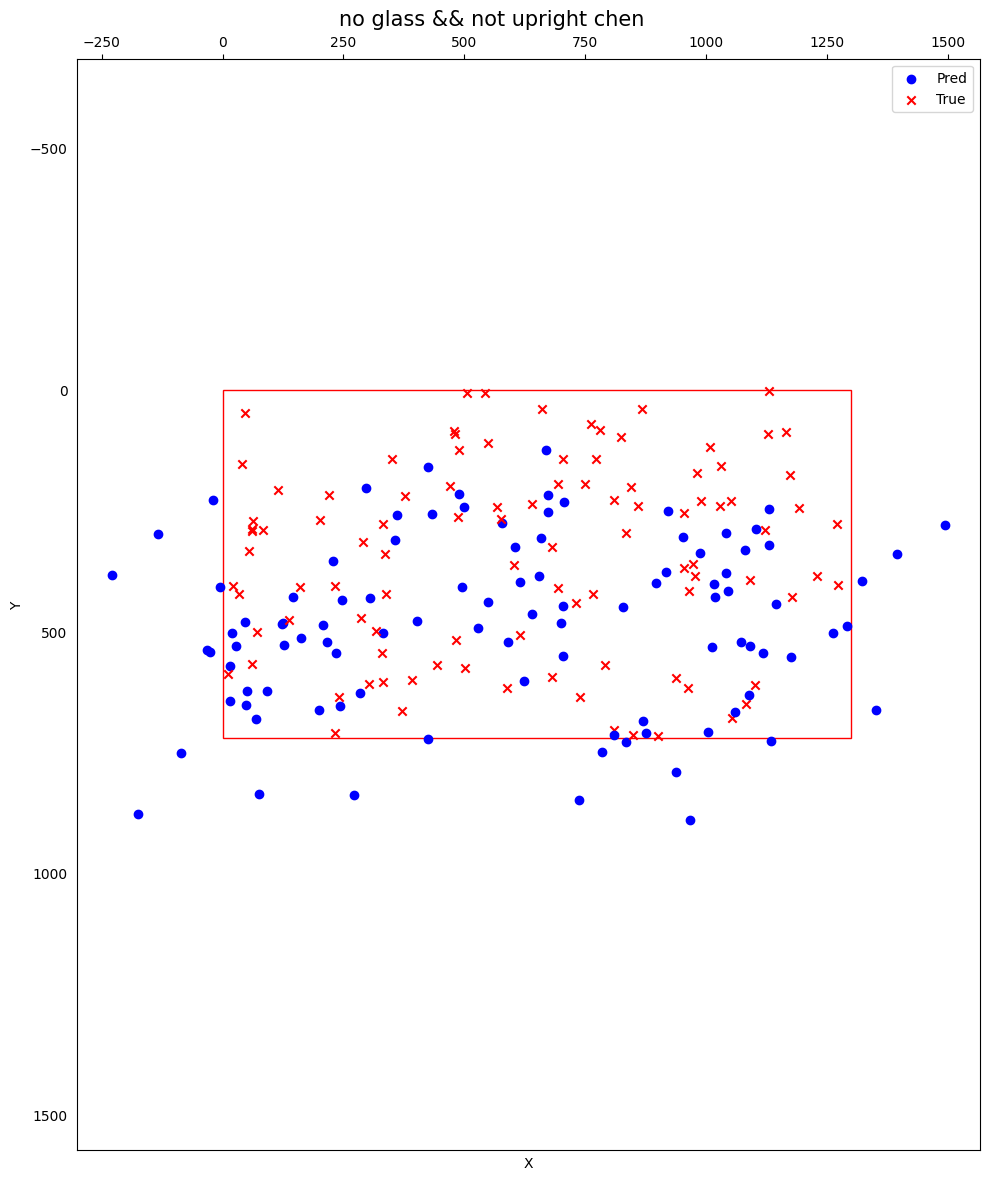

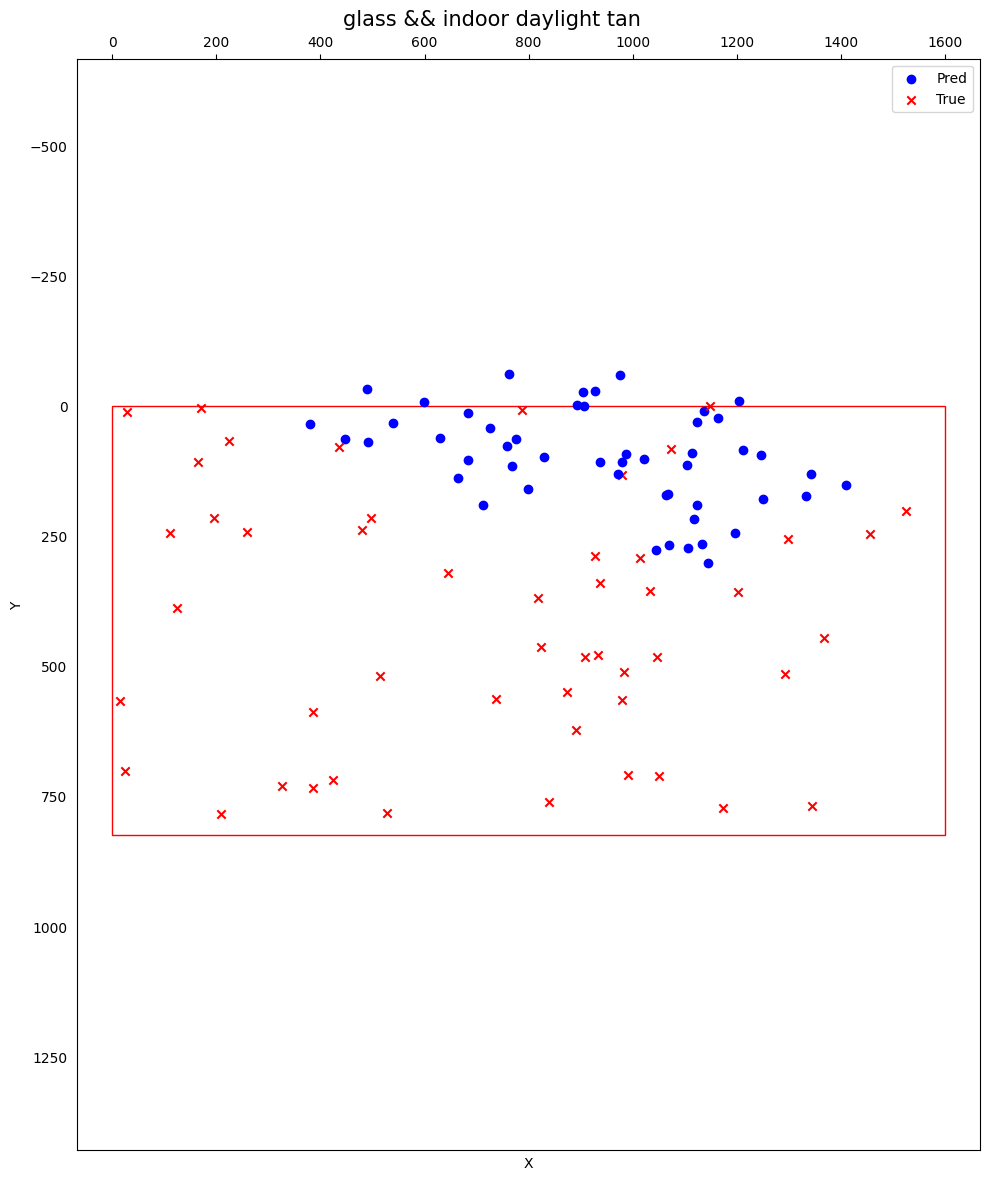

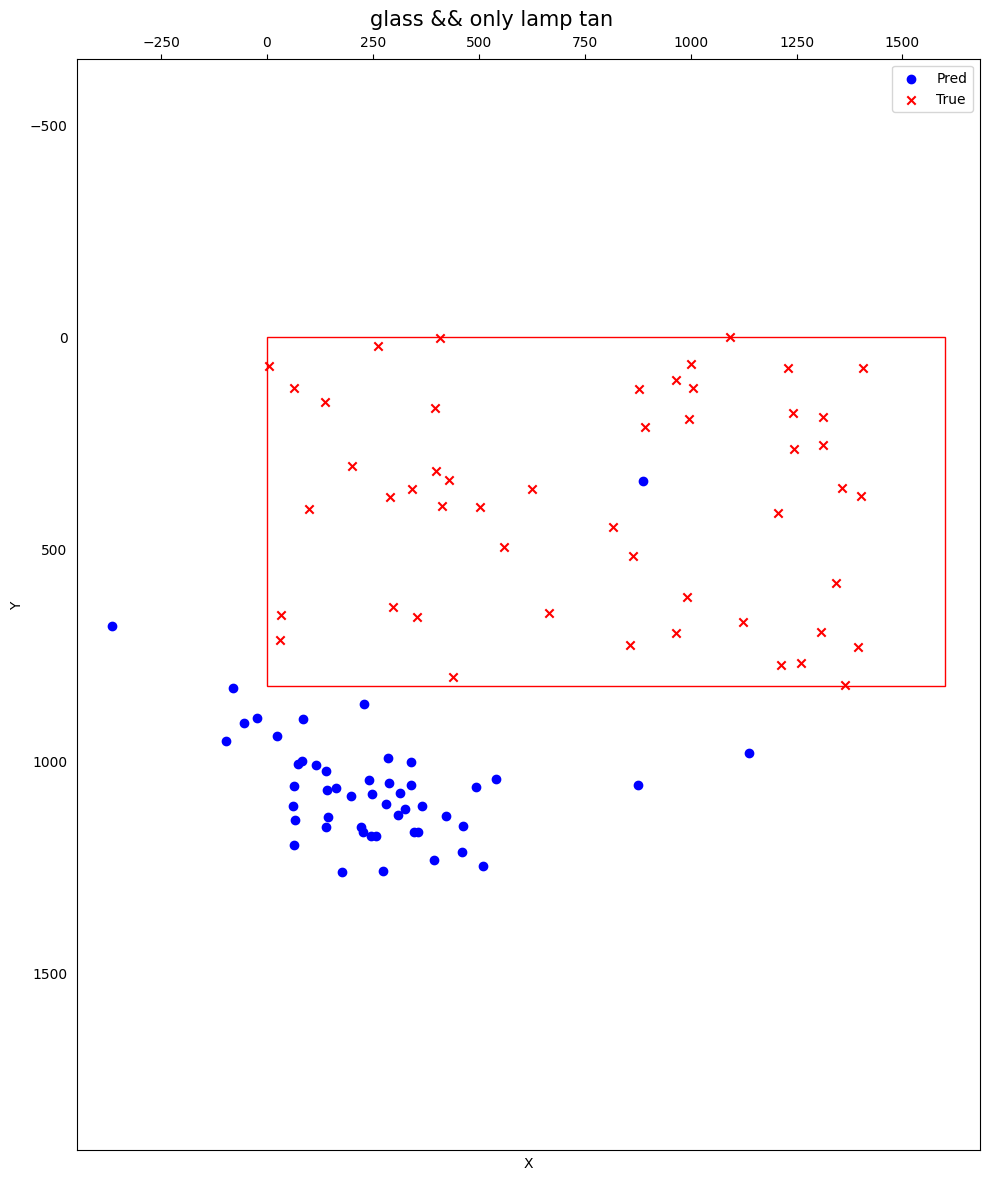

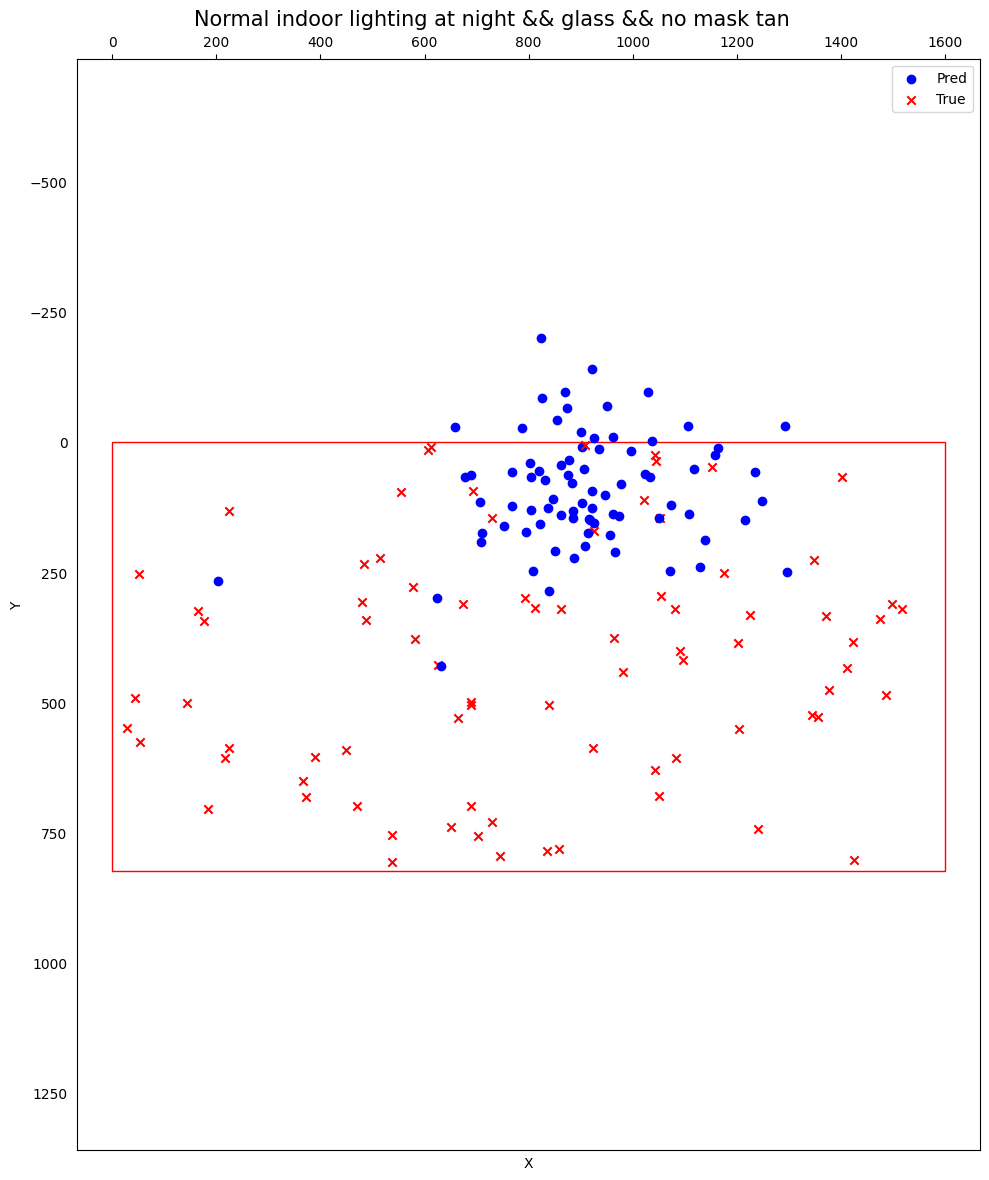

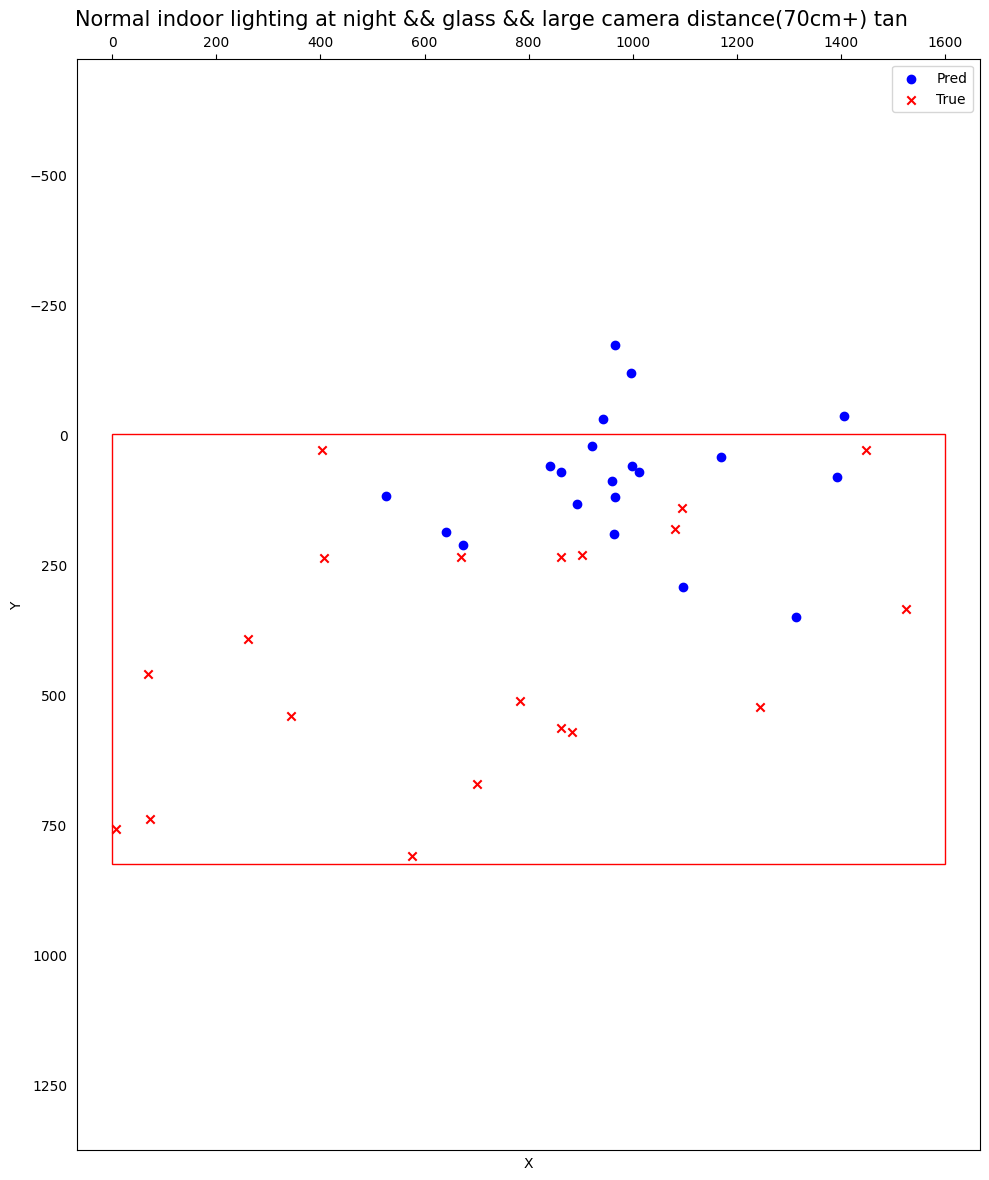

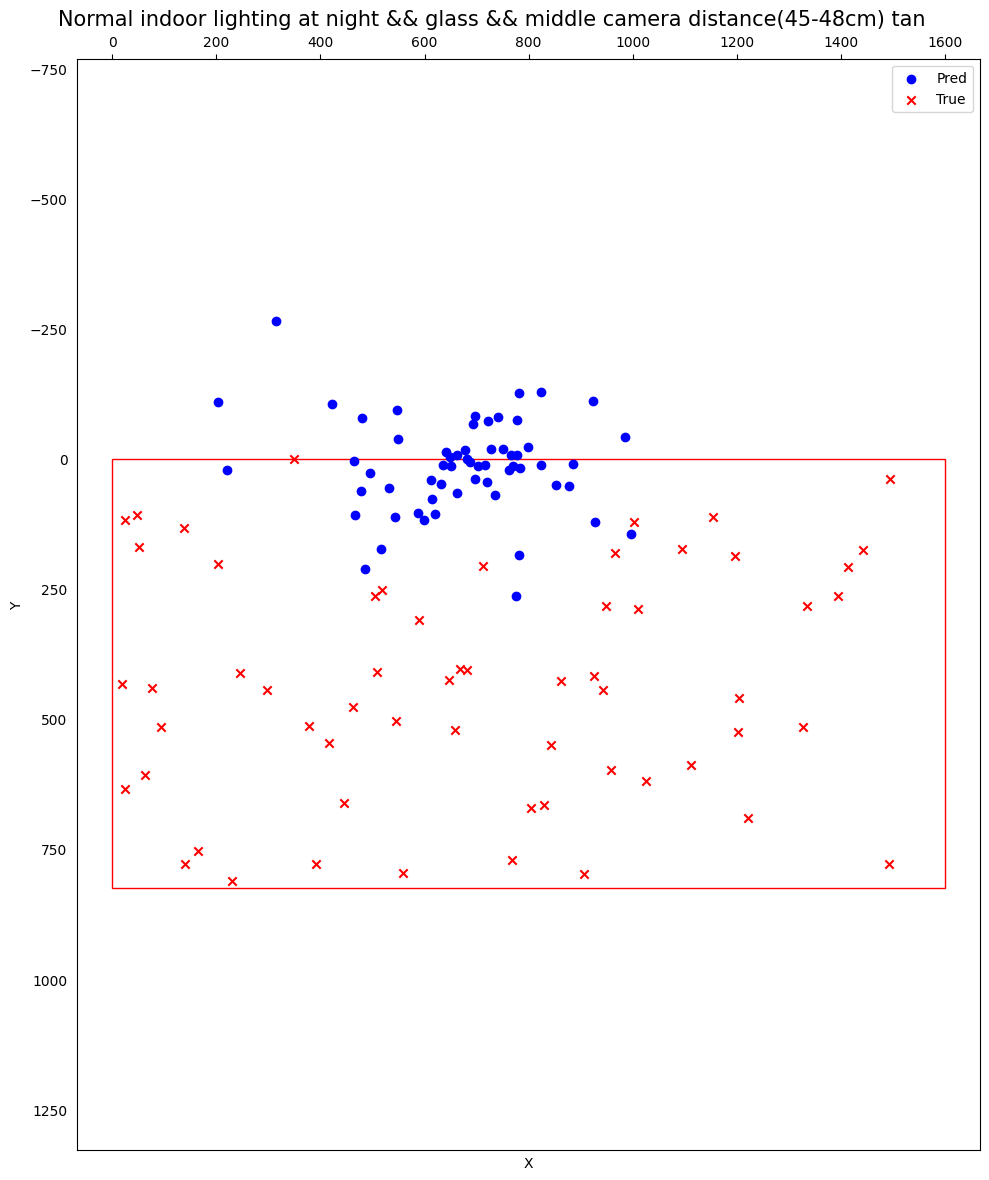

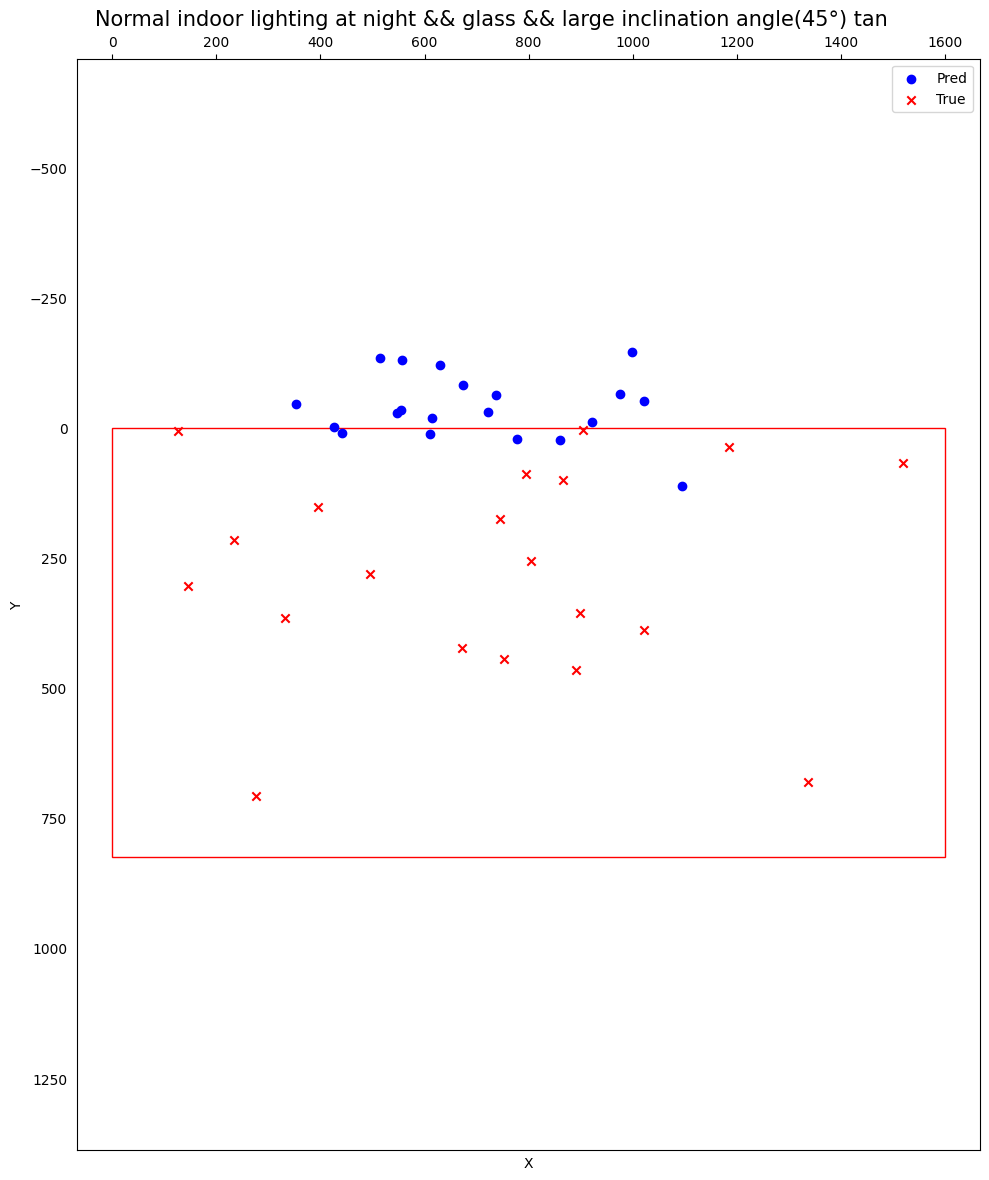

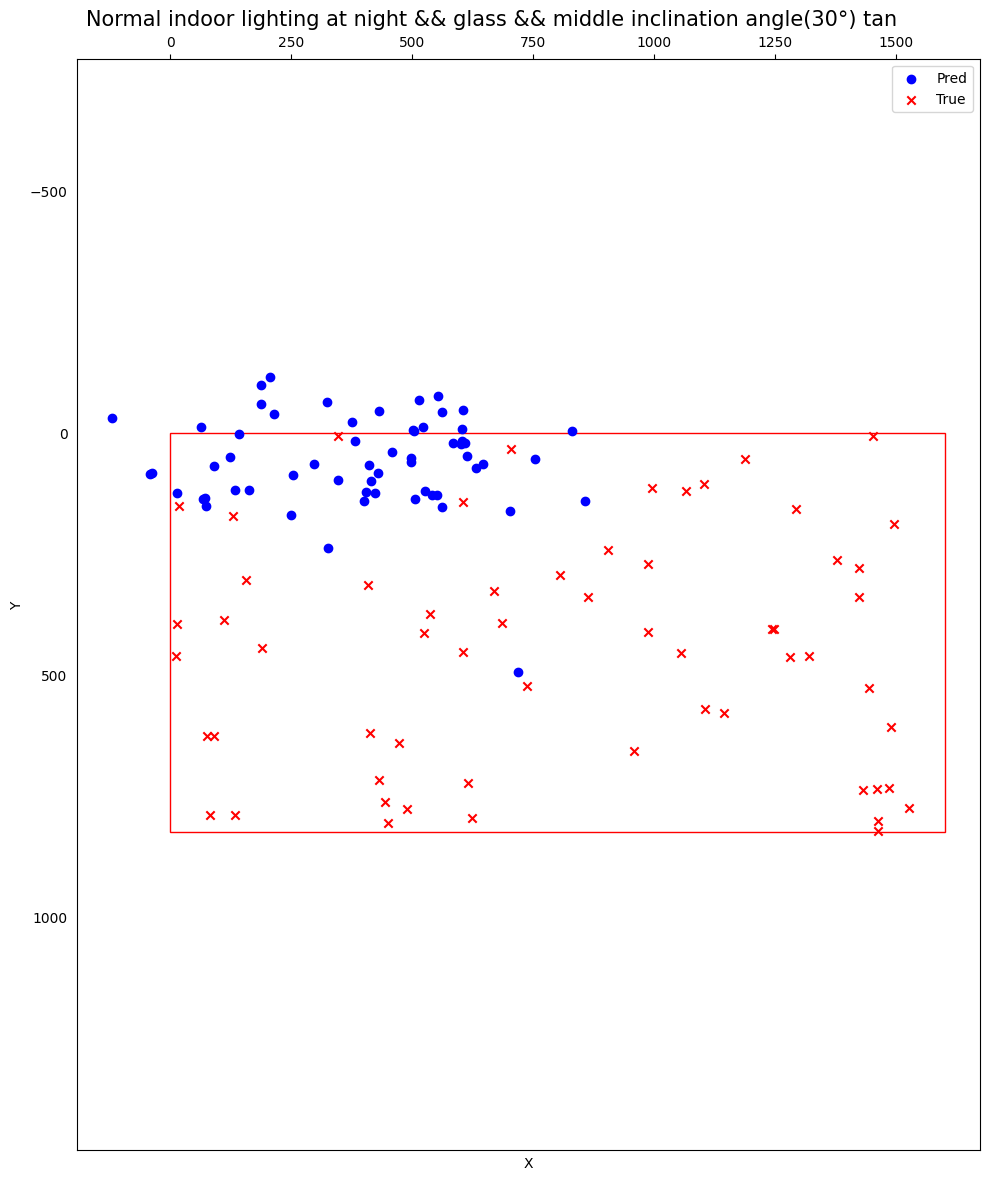

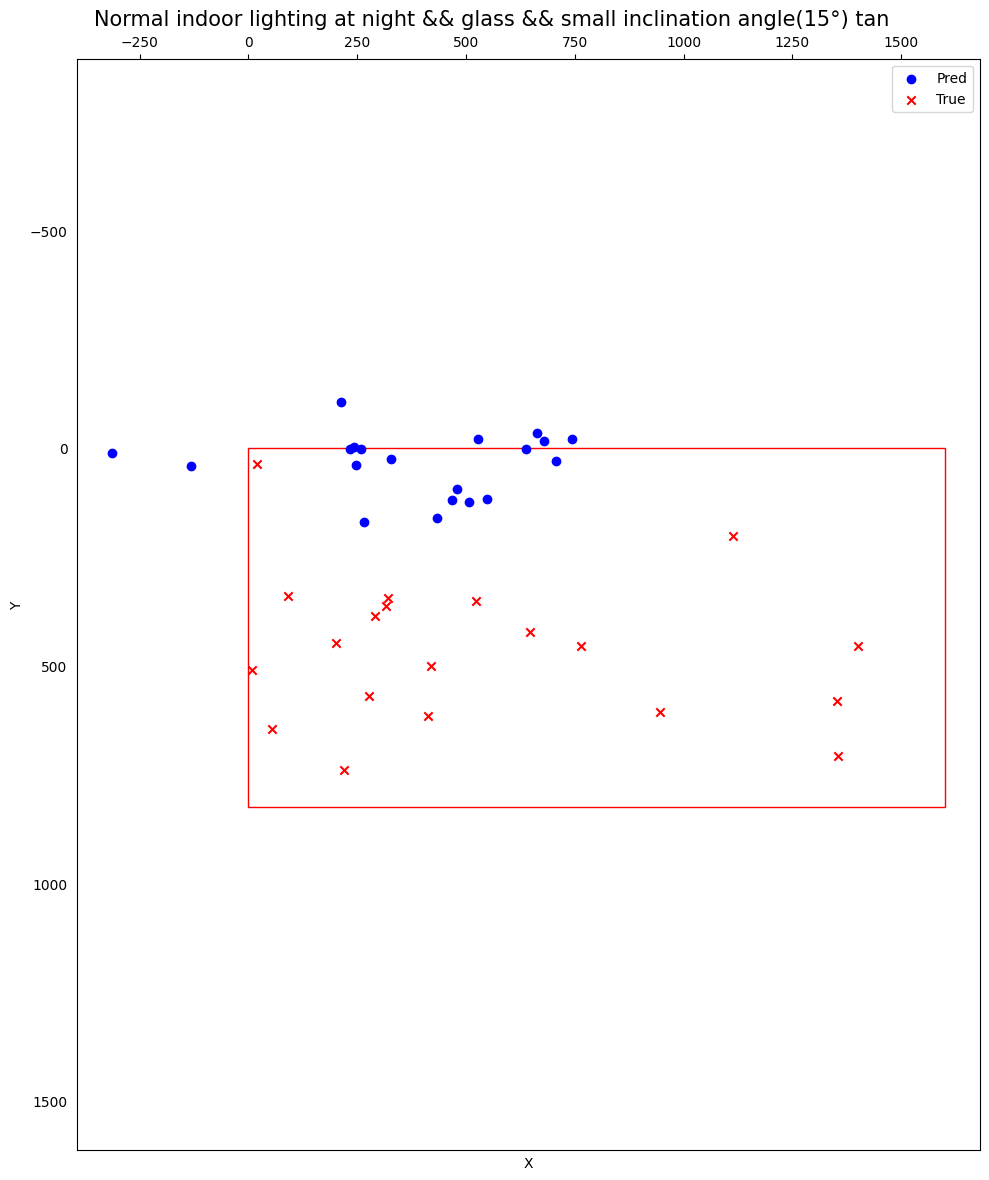

In [22]:
for i in [7, 8, 12, 22, 24, 26, 30, 32, 34]:
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot()
    if i%2==0:
        rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
    else:
        rect = plt.Rectangle((0, 0), 1300, 720, edgecolor='r', facecolor='None')
    ax.add_patch(rect)
    for j in range(len(datalist_group[i])):
        plt.scatter(datalist_group[i][j].gaze_point[0], datalist_group[i][j].gaze_point[1], marker='o',color = 'b', label=f'Pred')
        # plt.scatter(pred_gc_org[i][j][0]-(np.mean(pred_gc_org[i][:][0])-np.mean(pred_gc_org[0][:][0])), pred_gc_org[i][j][1]-(np.mean(pred_gc_org[i][:][1])-np.mean(pred_gc_org[0][:][1])), marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(refine_pred[i][j][0], refine_pred[i][j][1], marker='o', color=colors[0], label=f'SC Pred')
        #plt.scatter(final_pred[i][j][0], final_pred[i][j][1], marker='o',color = colors[2], label=f'PT Pred')
        plt.scatter(datalist_group[i][j].label[0], datalist_group[i][j].label[1], marker='x', color = 'r', label=f'True')
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], refine_pred[i][j][0] - ground_truth[i][j][0], refine_pred[i][j][1] - ground_truth[i][j][1], color=colors[0], alpha=0.5)
        #plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], final_pred[i][j][0] - ground_truth[i][j][0], final_pred[i][j][1] - ground_truth[i][j][1], color=colors[2], alpha=0.5)
        if (j == 0):
            plt.legend()
    plt.suptitle(f'{condition_label[i]} ', fontsize=15)
    # 将x坐标轴放在上方
    plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
    plt.gca().xaxis.set_ticks_position('top')
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.legend()
    plt.tight_layout()
    # 将坐标原点设置在左上角
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
import gaze_normalize
import importlib

importlib.reload(gaze_normalize)

for condition in datalist_group.keys():
    save_path = '/home/hgh/hghData/Datasets2/result_hr'
    for data in datalist_group[condition]:
        data.image = cv2.imread(data.image_path)
        image_out = data.draw_norm_gaze()
        cv2.imwrite(os.path.join(save_path, data.image_name),image_out)

In [23]:
# 绘制Jitter
print(data.hr)
print(np.ravel(warp_norm.hr_to_pitchyaw(data.hr)))

[[-0.20025976  0.08971384  0.01130201]]
[-11.47596564   5.17055681   0.13026682]


In [60]:
mean_eular = []
mean_ht =[]
mean_brightness = []
mean_contrast = []
result_scale = []
for condition in datalist_group.keys():
    if (condition in [12, 24, 30, 32, 34]) or diffusion_scale[condition] == -1:
        continue
    result_scale.append(diffusion_scale[condition])
    mean_eular.append(np.mean(np.asarray(eulars[condition]).reshape((-1,3)),axis = 0))
    mean_ht.append(np.mean(np.asarray(hts[condition]).reshape((-1,3)),axis = 0))
    mean_brightness.append(np.mean(brightness[condition]))
    mean_contrast.append(np.mean(contrast[condition]))

In [51]:
# 表示每个数据
# 绘制图像
fig = plt.figure(figsize=(10, 12))
x = range(len(diffusion_scale))
plt.scatter(x,diffusion_scale)
plt.ylabel('Diffusion Scale')
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/Diffusion_Scale.png')
plt.close()

## 表示每个数据

In [61]:
# 表示每个数据
# 绘制图像

fig = plt.figure(figsize=(10, 12))

plt.scatter([hr[0] for hr in mean_eular],result_scale)
plt.xlabel('Pitch [deg]')
plt.ylabel('Diffusion Scale')
# plt.xlim(-30, -20)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Pitch and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/pitch.png')
plt.close()


fig = plt.figure(figsize=(10, 12))

plt.scatter([hr[1] for hr in mean_eular],result_scale)
plt.xlabel('Yaw [deg]')
plt.ylabel('Diffusion Scale')
# plt.xlim(-5, -20)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Yaw and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/yaw.png')
plt.close()


fig = plt.figure(figsize=(10, 12))

plt.scatter([hr[2] for hr in mean_eular],result_scale)
plt.xlabel('Roll [deg]')
plt.ylabel('Diffusion Scale')
# plt.xlim(-20, 20)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Roll and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/roll.png')
plt.close()


fig = plt.figure(figsize=(10, 12))

plt.scatter([ht[0] for ht in mean_ht],result_scale)
plt.xlabel('ht x [mm]')
plt.ylabel('Diffusion Scale')
# plt.xlim(-50, -100)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Ht_x and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/ht_x.png')
plt.close()


fig = plt.figure(figsize=(10, 12))

plt.scatter([ht[1] for ht in mean_ht],result_scale)
plt.xlabel('ht y [mm]')
plt.ylabel('Diffusion Scale')
# plt.xlim(20, 50)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Ht_y and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/ht_y.png')
plt.close()


fig = plt.figure(figsize=(10, 12))

plt.scatter([ht[2] for ht in mean_ht],result_scale)
plt.xlabel('ht z [mm]')
plt.ylabel('Diffusion Scale')
# plt.xlim(450, 500)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Ht_z and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/ht_z.png')
plt.close()

fig = plt.figure(figsize=(10, 12))

plt.scatter(mean_brightness,result_scale)
plt.xlabel('Brightness')
plt.ylabel('Diffusion Scale')
# splt.xlim(40, 200)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Brightness and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/brightness.png')
plt.close()

fig = plt.figure(figsize=(10, 12))

plt.scatter(mean_contrast,result_scale)
plt.xlabel('Contrast')
plt.ylabel('Diffusion Scale')
# plt.xlim(20, 80)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Contrast and Diffusion Scale')   

plt.savefig('/home/hgh/hghData/Datasets2/result_diffusion/contrast.png')
plt.close()



Text(0.5, 0.98, 'Ht Y and Diffusion Scale')

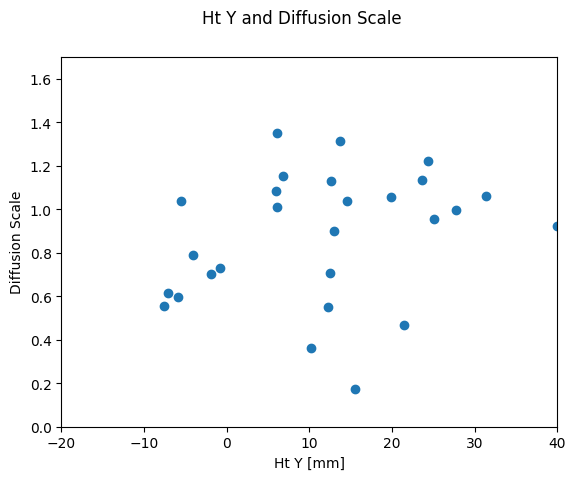

In [75]:
fig = plt.figure()

plt.scatter([ht[1] for ht in mean_ht],result_scale)
plt.xlabel('Ht Y [mm]')
plt.ylabel('Diffusion Scale')
plt.xlim(-20,40)
plt.ylim(0,1.7)
# axes[0,0].set_ylabel('Gaze Error [pixel]')


plt.suptitle(f'Ht Y and Diffusion Scale')   

In [77]:
filtered_ht = [ht[1] for ht in mean_ht if  20 < ht[1] < 40]
filtered_result_scale = [result_scale[i] for i, ht in enumerate(mean_ht) if 20 < ht[1] < 40]

correlation_coefficient = np.corrcoef(filtered_ht, filtered_result_scale)[0, 1]

print(correlation_coefficient)

0.15146709297634517


In [ ]:
import numpy as np

filtered_ht = [ht[1] for ht in mean_eular]

correlation_coefficient = np.corrcoef(filtered_ht, result_scale)[0, 1]

print(correlation_coefficient)


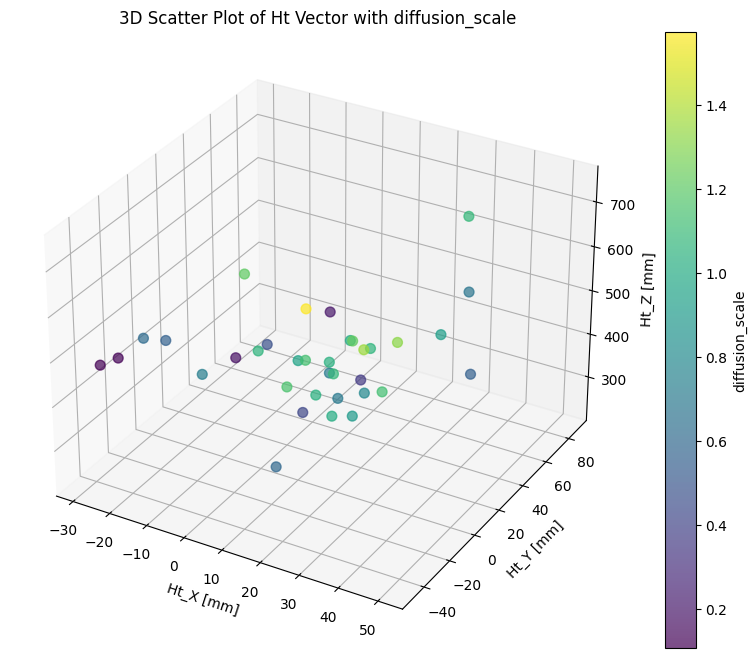

In [69]:
# 创建3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用欧拉角分量作为X, Y, Z轴的坐标
x = [ht[0] for ht in mean_ht]
y = [ht[1] for ht in mean_ht]
z = [ht[2] for ht in mean_ht]

# 使用diffusion_scale的值作为颜色
colors = result_scale

# 绘制散点图，这里我们暂时使用相同大小的点
sc = ax.scatter(x, y, z, c=colors, cmap='viridis', alpha=0.7, s=50)


# 添加颜色条
plt.colorbar(sc, ax=ax, label='diffusion_scale')

# 设置轴标签
ax.set_xlabel('Ht_X [mm]')
ax.set_ylabel('Ht_Y [mm]')
ax.set_zlabel('Ht_Z [mm]')

# 设置标题
ax.set_title('3D Scatter Plot of Ht Vector with diffusion_scale')

plt.show()


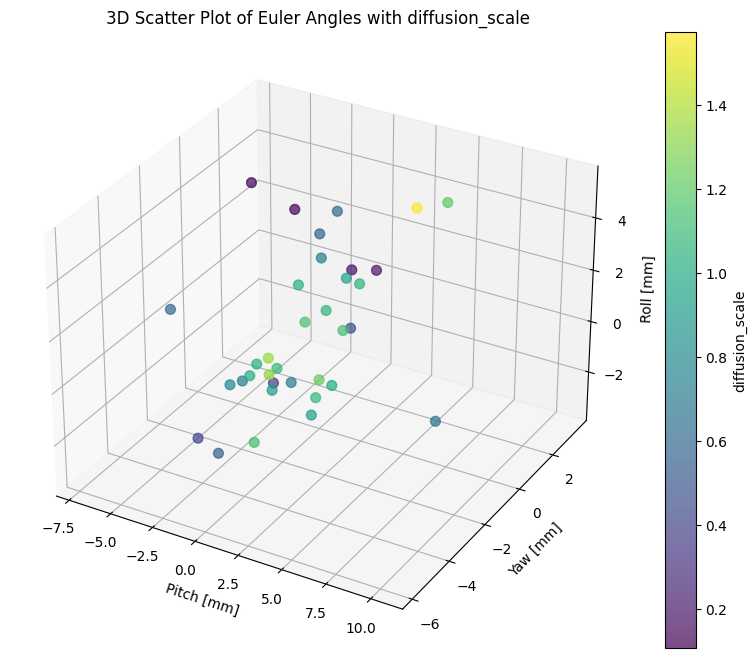

In [70]:
# 创建3D图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用欧拉角分量作为X, Y, Z轴的坐标
x = [hr[0] for hr in mean_eular]
y = [hr[1] for hr in mean_eular]
z = [hr[2] for hr in mean_eular]

# 使用diffusion_scale的值作为颜色
colors = result_scale

# 绘制散点图，这里我们暂时使用相同大小的点
sc = ax.scatter(x, y, z, c=colors, cmap='viridis', alpha=0.7, s=50)


# 添加颜色条
plt.colorbar(sc, ax=ax, label='diffusion_scale')

# 设置轴标签
ax.set_xlabel('Pitch [mm]')
ax.set_ylabel('Yaw [mm]')
ax.set_zlabel('Roll [mm]')

# 设置标题
ax.set_title('3D Scatter Plot of Euler Angles with diffusion_scale')

plt.show()


In [44]:
for i, condition in enumerate(condition_label):
    if condition == 'Normal indoor lighting at night && glass && large camera distance(70cm+) tan':
        print(i)

24


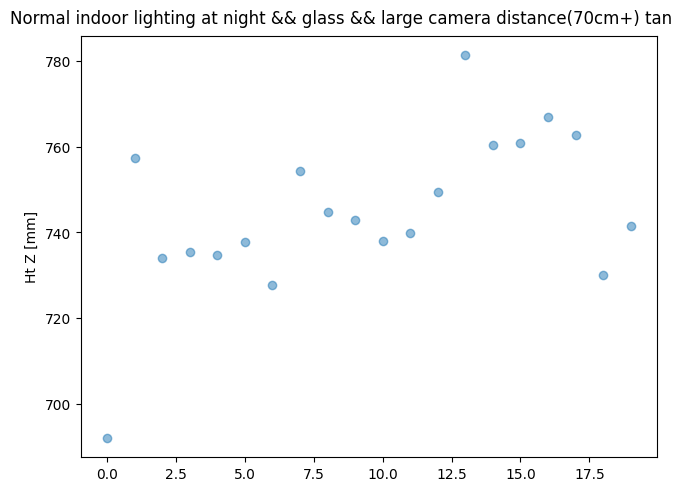

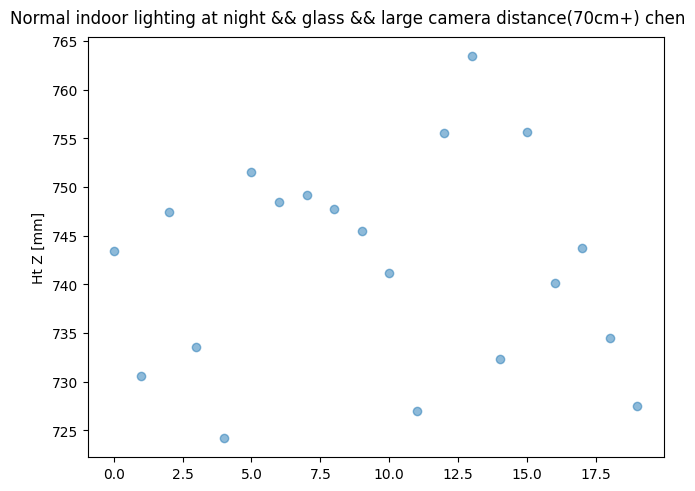

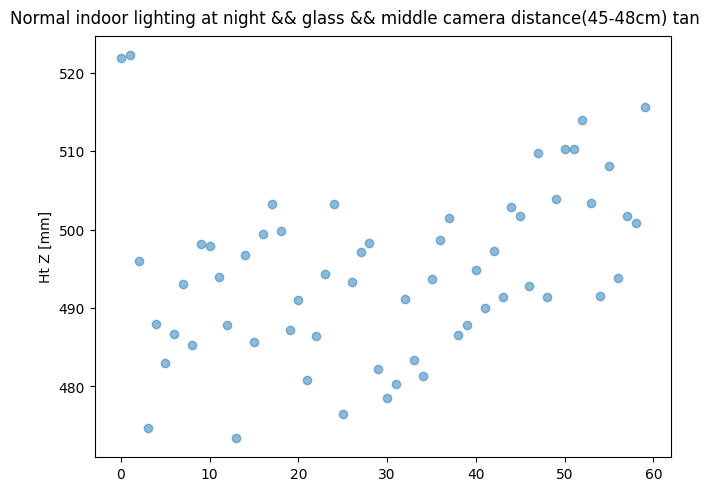

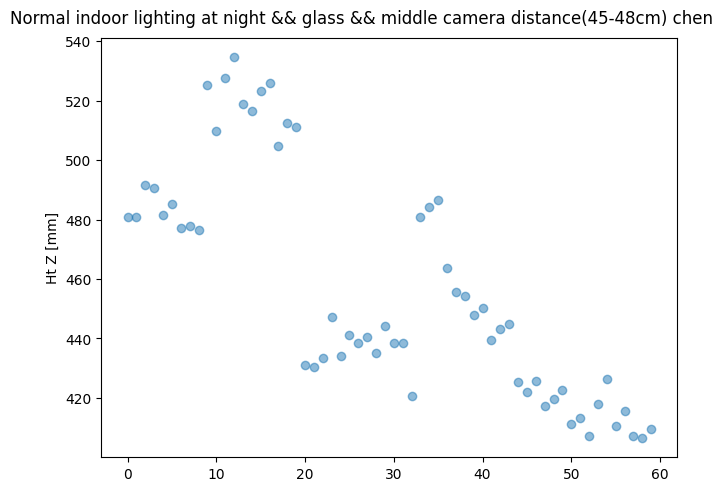

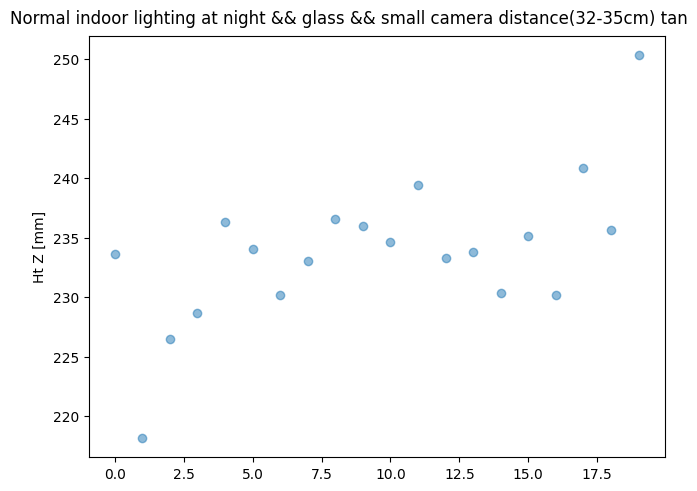

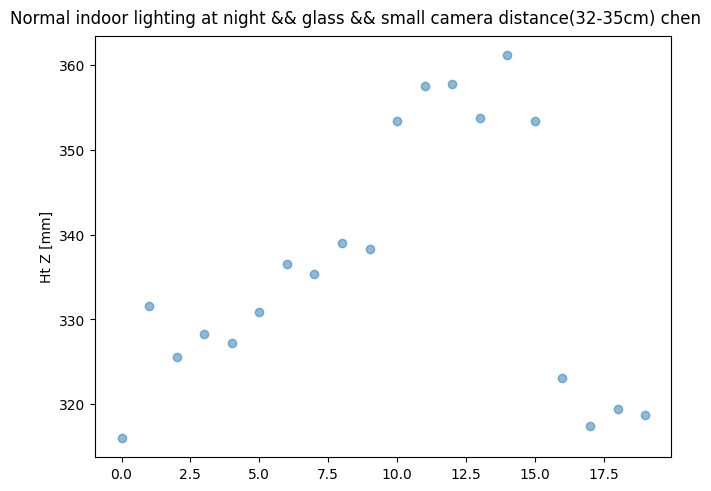

In [84]:
# 表示每个数据
for condition, list in datalist_group.items():
    if condition in [24, 25, 26, 27, 28, 29]:
        x = range(len(list))
        # 绘制图像
        fig, axes = plt.subplots(1, 1, constrained_layout=True)
        # pitch 
        axes.scatter(x,[ht[0][2] for ht in hts[condition]],alpha=0.5)
        #axes.set_ylim(300,400)
        axes.set_ylabel('Ht Z [mm]')
        # axes[0,0].set_ylabel('Gaze Error [pixel]')

        plt.suptitle(f'{condition_label[condition]}')   

        # plt.savefig('/home/hgh/hghData/Datasets2/result_bright_contrast/{}.png'.format(condition_label[condition]))
        # plt.close()

In [90]:
for condition, list in datalist_group.items():
    if condition in [26,27,28, 29]:
        array = np.array([ht[0][2] for ht in hts[condition]])
        print(array)
        count_in_range = np.sum((array >= 320) & (array <= 350))
        total_count = array.size
        proportion = count_in_range / total_count

        print("元素在45至48之间的比例:", proportion)

[521.9178628  522.27005512 496.04527549 474.73152306 487.99289486
 482.98875759 486.65466332 493.09779356 485.29998515 498.13020372
 497.91064355 493.99539978 487.8450659  473.41719795 496.69333916
 485.69079743 499.43211453 503.23489882 499.83747565 487.24481591
 491.05072001 480.86555656 486.42566413 494.38523402 503.21529202
 476.53868826 493.32068481 497.1130929  498.26869292 482.21833877
 478.55808532 480.29536812 491.20706592 483.41253035 481.29155988
 493.67065458 498.65167221 501.43616987 486.5638927  487.86329837
 494.85452257 490.05348129 497.20313716 491.41693613 502.90245017
 501.70200519 492.8666534  509.7078678  491.36993788 503.89358219
 510.24345557 510.25576377 513.99562208 503.39508901 491.54690918
 508.07321087 493.83380382 501.78068606 500.8081653  515.65267613]
元素在45至48之间的比例: 0.0
[480.98932057 480.84064795 491.50178621 490.66604329 481.42262504
 485.11329243 477.28860823 477.71546414 476.43281449 525.15637959
 509.78902425 527.73334539 534.68678818 518.90666223 516

# 使用LME分析近似图片(abort)

## 寻找近似图片：gt相近+图像相似度高

In [ ]:
# # 读取数据
# with open('/home/hgh/hghData/all_3_5.pkl', 'rb') as fo:
#     datalist = pickle.load(fo, encoding='bytes')
# with open('/home/hgh/hghData/gaze_pred_3_5.pkl', 'rb') as fo:
#     predlist = pickle.load(fo, encoding='bytes')

In [ ]:
# data_dict = '/home/hgh/hghData/Datasets2/Photo'
# def euclidean_distance(point1,point2):
#     return np.lingalg.norm(point1 - point2)

In [ ]:
# threshold = 10
# close_points = []
# for i in range(len(datalist)):
#     for j in range(i+1, len(datalist)):
#         if datalist[i].label[0] == -1 or datalist[j].label[0] == -1 :
#             continue
#         distance = np.linalg.norm(np.array([datalist[i].label[0],datalist[i].label[1]])-np.array([datalist[j].label[0],datalist[j].label[1]]))
#         # print(distance)
#         if distance <= threshold:
#             close_points.append((datalist[i].image_name,datalist[j].image_name))

# print(len(close_points))

In [ ]:
# ## 对于上面的图片组，根据SSIM进一步筛选
# from skimage.metrics import structural_similarity as ssim
# from skimage import io

# close_images =[]
# for image_pair in close_points:
#     # 计算原图像的SSIM
#     image1 = io.imread(os.path.join(data_dict,image_pair[0]))
#     image2 = io.imread(os.path.join(data_dict,image_pair[1]))
#     ssim_score = ssim(image1, image2, multichannel=True, channel_axis=2)
#     if ssim_score >= 0.8:
#         close_images.append(image_pair)


In [ ]:
# print(close_images)

In [ ]:
# # 构建一个字典，将每个点映射到与其距离相近的点的集合
# temp_dict = {}
# point_dict = []
# for pair in close_images:
#     for point in pair:
#         if point not in point_dict:
#             temp_dict[point] = set()
#             point_dict.append(point)
#         temp_dict[point].update(pair)

# # 打印合并后的点集合
# # for point, neighbors in temp_dict.items():
# #     print(f"点 {point} 的相近点集合:", neighbors)

# print(point_dict)        



## KMeans聚类

In [ ]:
# labels_tan = []
# labels_chen = []
# for image in point_dict:
#     found_objects = [obj for obj in datalist if obj.image_name == image]
#     if get_condition_number(int(os.path.splitext(image)[0])) % 2 == 0:
#         labels_tan.append(list(found_objects[0].label))
#     else:
#         labels_chen.append(list(found_objects[0].label))
# labels_tan = np.asarray(labels_tan).reshape((-1,2))
# labels_chen = np.asarray(labels_chen).reshape((-1,2))

# plt.scatter(labels_tan[:,0], labels_tan[:,1], marker='o', label=f'tan')
# plt.scatter(labels_chen[:,0], labels_chen[:,1], marker='o', label=f'chen')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('close groundtruth gaze points')
# plt.show()
    

In [ ]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # 创建 KMeans 聚类模型并指定聚类数
# kmeans = KMeans(n_clusters=23)
# kmeans.fit(labels_chen)

# # 获取每个点所属的聚类标签
# clusters_labels_chen = kmeans.labels_

# # 将 points 列表解压为 x 和 y 坐标列表
# x_coords, y_coords = zip(*labels_chen)

# # 绘制散点图，并根据聚类标签使用不同颜色绘制
# plt.scatter(x_coords, y_coords, c=clusters_labels_chen, cmap='viridis')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('close groundtruth gaze points')
# plt.colorbar(label='clusters')
# plt.show()


In [ ]:
# # 创建 KMeans 聚类模型并指定聚类数
# kmeans = KMeans(n_clusters=7)
# kmeans.fit(labels_tan)

# # 获取每个点所属的聚类标签
# clusters_labels_tan = kmeans.labels_

# # 将 points 列表解压为 x 和 y 坐标列表
# x_coords, y_coords = zip(*labels_tan)

# # 绘制散点图，并根据聚类标签使用不同颜色绘制
# plt.scatter(x_coords, y_coords, c=clusters_labels_tan, cmap='viridis')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('close groundtruth gaze points')
# plt.colorbar(label='clusters')
# plt.show()


In [ ]:
# data_tan = []
# data_chen = []
# for image in point_dict:
#     found_objects = [obj for obj in datalist if obj.image_name == image]
#     if get_condition_number(int(os.path.splitext(image)[0])) % 2 == 0:
#         data_tan.append(found_objects[0])
#     else:
#         data_chen.append(found_objects[0])

# chen_clusters = {}

# for i, data in enumerate(data_chen):
#     if clusters_labels_chen[i] not in chen_clusters:
#         chen_clusters[clusters_labels_chen[i]] = []
#     chen_clusters[clusters_labels_chen[i]].append(data)

# tan_clusters = {}

# for i, data in enumerate(data_tan):
#     if clusters_labels_tan[i] not in tan_clusters:
#         tan_clusters[clusters_labels_tan[i]] = []
#     tan_clusters[clusters_labels_tan[i]].append(data)

# 观察每簇的hr和ht(abort)

In [ ]:
# # chen
# for key, value in chen_clusters.items():
#     print('cluster {}'.format(key))
#     for val in value:
#         print(val.image_name.ljust(10), end = ' ')
#         eular = warp_norm.hr_to_pitchyaw(val.hr)
#         print('pitch: {:.2f}, yaw: {:.2f}, roll: {:.2f}'.format(eular[0,0],eular[0,1],eular[0,2]))
#         print(' '.ljust(10), end = ' ')
#         print('ht:{:.2f} {:.2f} {:.2f}'.format(val.ht[0,0], val.ht[0,1], val.ht[0,2]))


In [ ]:
# # tan   
# for key, value in tan_clusters.items():
#     print('cluster {}'.format(key))
#     for val in value:
#         print(val.image_name.ljust(10), end = ' ')
#         eular = warp_norm.hr_to_pitchyaw(val.hr)
#         print('pitch: {:.2f}, yaw: {:.2f}, roll: {:.2f}'.format(eular[0,0],eular[0,1],eular[0,2]))
#         print(' '.ljust(10), end = ' ')
#         print('ht:{:.2f} {:.2f} {:.2f}'.format(val.ht[0,0], val.ht[0,1], val.ht[0,2]))
#         print(val.pred_gaze)

In [ ]:
# print('load gaze estimator')
# model_path = './ckpt/epoch_24_ckpt.pth.tar'
# model = gaze_network()
# model.cuda()
# pre_trained_model_path = model_path
# if not os.path.isfile(pre_trained_model_path):
#     print('the pre-trained gaze estimation model does not exist.')
#     exit(0)
# else:
#     print('load the pre-trained model: ', pre_trained_model_path)
# ckpt = torch.load(pre_trained_model_path)
# model.load_state_dict(ckpt['model_state'], strict=True)  # load the pre-trained model
# model.eval()  # change it to the evaluation mode

# data = tan_clusters[4][1]
# data.pred(model, data.warp_image)
# data.image_name = cv2.imread(os.path.join('/home/hgh/hghData/Datasets2/Photo','2244.jpg'))
# data.Ear = -1
# image_out = data.draw_gaze()
# cv2.imwrite('./result/1.jpg', image_out)

In [ ]:
# with open('/home/hgh/hghData/close_image.pkl', 'wb') as fo:
#     pickle.dump(close_images,fo)

# 可靠性检验(abort)
## 对部分数据集作扰动

In [ ]:
# image_folder_path = '/home/hgh/hghData/Datasets2/part'
# save_dir = '/home/hgh/hghData/Datasets2/part_preprocess'
# csv_file_path = '/home/hgh/hghData/Datasets2/coordinate.csv'
# df = pd.read_csv(csv_file_path, header=None)
# preds = gaze_normalize.xmodel()

# org_data = []
# #遍历图像文件夹
# for filename in sorted(os.listdir(image_folder_path), key=lambda x: int(os.path.splitext(x)[0])):
#     if filename.endswith(".jpg"):
#         # 构建图像文件的完整路径
#         image_path = os.path.join(image_folder_path, filename)
#         print(image_path)
#         try:
#             row = df.iloc[int(os.path.splitext(filename)[0]) - 1].tolist()
#             label = (int(row[3]),int(row[4]))
#         except:
#             st()
#         print(label)
#         gaze_normalize_new = gaze_normalize.GazeNormalize(filename,label,camera_matrix_tan,camera_distortion_tan,preds)
#         save_path = os.path.join(save_dir, f'{filename}')
#         warp_image = gaze_normalize_new.norm(image_folder_path)
#         # if gaze_normalize_new.err == False:
#         #     cv2.imwrite(save_path, warp_image)
#         org_data.append(gaze_normalize_new)

In [ ]:
# import math
# # # 确保欧拉角转换流程无误
# # for i in range(20):
# #     print('hr:',org_data[i].hr)
# #     print('euler:',warp_norm.hr_to_pitchyaw(org_data[i].hr))
# #     euler = warp_norm.hr_to_pitchyaw(org_data[i].hr) 
# #     print('re hr:', warp_norm.pitchyaw_to_hr(euler))
# #     print('-----')

# # 操作流程
# # 对hr作调整
# condit_dict = []
# epi  = 0.02

# face_model_load = np.loadtxt('./modules/face_model.txt')  # Generic face model with 3D facial landmarks
# landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
# face_model = face_model_load[landmark_use, :]

# print('load gaze estimator')
# model_path = './ckpt/epoch_24_ckpt.pth.tar'
# model = gaze_network()
# model.cuda()
# pre_trained_model_path = model_path
# if not os.path.isfile(pre_trained_model_path):
#     print('the pre-trained gaze estimation model does not exist.')
#     exit(0)
# else:
#     print('load the pre-trained model: ', pre_trained_model_path)
# ckpt = torch.load(pre_trained_model_path)
# model.load_state_dict(ckpt['model_state'], strict=True)  # load the pre-trained model
# model.eval()  # change it to the evaluation mode

# for i in range(20):
#     for j in range(-100,110):
#         temp = copy.deepcopy(org_data[i])

#         temp.face_center[2,0] += epi*j
#         print(temp.face_center[2,0])


#         focal_norm = 960
#         distance_norm = 600  # normalized distance between face and camera
#         roiSize = (224, 224)

#         ht = temp.ht.reshape((3,1))
#         hr = temp.hr.reshape((3,1))
#         hR = cv2.Rodrigues(hr)[0]  # rotation matrix, [3,3]
#         Fc = np.dot(hR, face_model.T) + ht # [3,50]
#         temp.face_center = np.mean(Fc,axis=1).reshape((3, 1))
#         temp.face_center[2,0] += epi*j
#         # normalize image
#         distance = np.linalg.norm(temp.face_center)  # actual distance between and original camera
#         z_scale = distance_norm / distance

#         cam_norm = np.array([
#             [focal_norm, 0, roiSize[0] / 2],
#             [0, focal_norm, roiSize[1] / 2],
#             [0, 0, 1.0],
#         ])
#         S = np.array([  # scaling matrix
#             [1.0, 0.0, 0.0],
#             [0.0, 1.0, 0.0],
#             [0.0, 0.0, z_scale],
#         ])

#         hRx = hR[:, 0]
#         forward = (temp.face_center / distance).reshape(3)
#         down = np.cross(forward, hRx)
#         down /= np.linalg.norm(down)
#         right = np.cross(down, forward)
#         right /= np.linalg.norm(right)

#         temp.R = np.c_[right, down, forward].T  # rotation matrix R
#         temp.W = np.dot(np.dot(cam_norm, S), np.dot(temp.R, np.linalg.inv(temp.camera_matrix)))  # transformation matrix
#         if temp.is_video:
#             image = temp.image_name
#         else:
#             image = cv2.imread(temp.image_path)

#         img_warped = cv2.warpPerspective(image, temp.W, roiSize) 

#         temp.pred(model, img_warped)
#         temp.vector_to_screen(pixel_scale_tan)
#         condit_dict.append(temp)

In [ ]:
# import math
# # # 确保欧拉角转换流程无误
# # for i in range(20):
# #     print('hr:',org_data[i].hr)
# #     print('euler:',warp_norm.hr_to_pitchyaw(org_data[i].hr))
# #     euler = warp_norm.hr_to_pitchyaw(org_data[i].hr) 
# #     print('re hr:', warp_norm.pitchyaw_to_hr(euler))
# #     print('-----')

# # 操作流程
# # 对hr作调整
# condit_dict = []
# epi  = 0.02

# face_model_load = np.loadtxt('./modules/face_model.txt')  # Generic face model with 3D facial landmarks
# landmark_use = [20, 23, 26, 29, 15, 19]  # we use eye corners and nose conners
# face_model = face_model_load[landmark_use, :]

# print('load gaze estimator')
# model_path = './ckpt/epoch_24_ckpt.pth.tar'
# model = gaze_network()
# model.cuda()
# pre_trained_model_path = model_path
# if not os.path.isfile(pre_trained_model_path):
#     print('the pre-trained gaze estimation model does not exist.')
#     exit(0)
# else:
#     print('load the pre-trained model: ', pre_trained_model_path)
# ckpt = torch.load(pre_trained_model_path)
# model.load_state_dict(ckpt['model_state'], strict=True)  # load the pre-trained model
# model.eval()  # change it to the evaluation mode

# for i in range(50):
#     temp = copy.deepcopy(org_data[i])
#     image_warp = temp.xtrans(face_model)
#     temp.pred(model, image_warp)
#     temp.vector_to_screen(pixel_scale_tan)
#     condit_dict.append(temp)

In [ ]:
# org_tan = np.array([800,0])#tan 1600*825
# # pred_gc_org[i] = org_tan + pred_gc[i]


## 对因变量作正态校验

In [ ]:
# # 合成dataframe
# subjects = []
# face_center = {}
# org_gaze = {}
# preds = {}
# for data in condit_dict:
#     if data.image_name not in subjects:
#         subjects.append(data.image_name)
#         face_center[data.image_name] = []
#         preds[data.image_name] = []
#         org_gaze[data.image_name] = []
#     face_center[data.image_name].append(data.face_center[2,0])
#     org_gaze[data.image_name].append(data.pred_gaze)
#     preds[data.image_name].append(data.gaze_point+org_tan)

# preds = {key: np.asarray(value) for key, value in preds.items()}

In [ ]:
# fig = plt.figure(figsize=(10, 12))
# ax = fig.add_subplot()
# rect = plt.Rectangle((0, 0), 1600, 825, edgecolor='r', facecolor='None')
# ax.add_patch(rect)
# for key, value in preds.items():
#     plt.scatter(value[0,0], value[0,1])
# # 将x坐标轴放在上方
# plt.tick_params(axis='both', which='both', bottom=False, top=True, left=False, right=False)
# plt.gca().xaxis.set_ticks_position('top')
# plt.axis('equal')
# plt.xlabel('X')
# plt.ylabel('Y')
# # plt.legend()
# plt.tight_layout()
# # 将坐标原点设置在左上角
# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
# from scipy import stats

# # 执行 Shapiro-Wilk (SW) 检验
# for name in subjects:
#     for i in range(2):
#         sw_statistic, sw_p_value = stats.shapiro(preds[name][:,i])
#         print("\nname:", name, i)
#         print("Shapiro-Wilk (SW) 检验结果:")
#         print("SW 统计量:", sw_statistic)
#         print("p 值:", sw_p_value)

## 回归

In [ ]:

# # 提取所有可能的 yaw 和 roll 的取值
# yaw_values = set()
# roll_values = set()

# for variables in variables_list:
#     yaw_values.add(variables[1])
#     roll_values.add(variables[2])

# # 对每组固定的 yaw 和 roll 值进行分析
# for yaw in yaw_values:
#     for roll in roll_values:
#         # 存储符合条件的 pitch 值
#         pitch_values = []

#         # 遍历自变量信息列表
#         for variables in variables_list:
#             # 检查当前数据是否符合固定的 yaw 和 roll 值
#             if variables[1] == yaw and variables[2] == roll:
#                 # 提取 pitch 值
#                 pitch_values.append(variables[0])

#         # 输出符合条件的 pitch 值
#         print(f"Yaw: {yaw}, Roll: {roll}, 符合条件的 pitch 值：{pitch_values}")

## 多因素方差分析

In [ ]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# data = {
#     'subject_id': subjects,
#     'pitch': pitch,
#     'yaw': yaw,
#     'roll': roll,
#     'prediction_x': preds[:,0],
#     'prediction_y': preds[:,1]
# }
# df = pd.DataFrame(data)
# formula_x = 'prediction_x ~ pitch + yaw + roll'
# formula_y = 'prediction_y ~ pitch + yaw + roll'
# model_x = smf.mixedlm(formula_x, data=data, groups=data['subject_id'])
# model_y = smf.mixedlm(formula_y, data=data, groups=data['subject_id'])


# result_x = model_x.fit()
# result_y = model_y.fit()

# # 打印方差分析结果
# print(result_x.summary())
# print(result_y.summary())


    